In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam 
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, GlobalMaxPooling2D, Flatten, Concatenate 
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.inception_resnet_v2 import InceptionResNetV2

%matplotlib inline

In [3]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import auc

In [4]:
import tensorflow as tf
import keras.callbacks
from keras import backend as K
config = tf.ConfigProto(intra_op_parallelism_threads=31, inter_op_parallelism_threads=1, allow_soft_placement=True)
session = tf.Session(config=config)
K.set_session(session)
os.environ["OMP_NUM_THREADS"] = "31"
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

### Data Generator

In [5]:
data_dir = './data/'

In [6]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', 
                                               limit=None, val_limit=None, norm='macenko')
len(x_train), len(x_valid)

(261756, 32728)

In [7]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [8]:
del train_id
del val_id
del data_dir

## MODEL

In [29]:
inputs = Input((224,224,3))

In [30]:
inception = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=inputs)

219062272/219055592 [==============================] - 142s 1us/step


In [31]:
# Train only the top layer
for layer in inception.layers:
    layer.trainable = False

In [ ]:
inception.layers.pop()

In [27]:
x = inception.output
x = Dense(128, activation='relu')(x)
y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities
model = Model(inputs=inception.input, outputs=y)

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_407 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_407 (BatchN (None, 111, 111, 32) 96          conv2d_407[0][0]                 
__________________________________________________________________________________________________
activation_407 (Activation)     (None, 111, 111, 32) 0           batch_normalization_407[0][0]    
__________________________________________________________________________________________________
conv2d_408

In [9]:
def build_arch_8_net():
    
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(96,96,3))
    x = vgg16.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities
    model = Model(inputs=vgg16.input, outputs=y)
    
    # Train only the top layer
    for layer in vgg16.layers:
        layer.trainable = False

    return model

In [10]:
model = build_arch_8_net()

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

### Compile

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000005)

In [13]:
optimizer = Adam(lr=0.001)
loss = 'binary_crossentropy'
metrics = ['acc', auc]

#### Load Model

In [16]:
dependencies = {
    'auc': auc
}

In [17]:
model = load_model('./Model/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_first10ep/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_epoch_10.h5',
                   custom_objects=dependencies)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [14]:
model.compile(optimizer, loss, metrics)

## Train the model

In [19]:
model_name = 'vgg16_model_bin_cross_arch_8_lr_0_001_inp96'

In [20]:
batch_size = 128
n_epoch = 10

# Parameters for generators
train_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
    'shuffle': True
}

val_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **val_params)


# Callbacks
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]

In [21]:
del x_train
del x_valid
del y_train
del y_valid
del train_labels
del val_labels

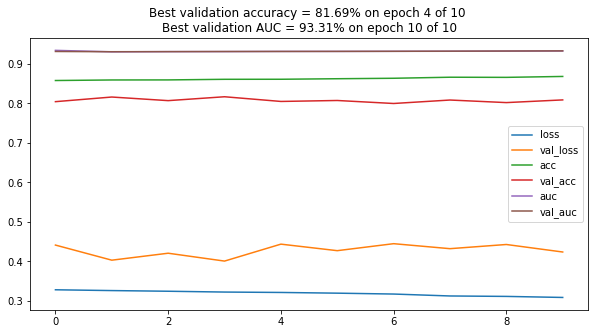

2044/2044 [==============================] - 1127s 552ms/step - loss: 0.3087 - acc: 0.8683 - auc: 0.9329 - val_loss: 0.4238 - val_acc: 0.8089 - val_auc: 0.9331


In [22]:
# Training - limitless - macenko - augmented
model.fit_generator(training_generator, validation_data=validation_generator,
                    epochs=n_epoch, callbacks=callbacks)